In [1]:
import keras
import cv2
from sklearn.cross_validation import train_test_split
from data_helper import *
import os
import shutil

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 加载数据(图片名以及标签)

In [2]:
%reload_ext autoreload 
from data_helper import *

from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *

from keras.applications import *
from keras.preprocessing.image import *
import numpy as np
from tqdm import tqdm
import cv2

def load_data(load_type="train"):
    path = None
    n = 25000
    if load_type=="train":
        imgs = []
        labels = []
        
        path = "train/"
        img_names = os.listdir(path)
        
        for name in img_names:
            imgs.append('train/'+name)
            labels.append([0] if name[:3] == 'cat' else [1])
            
        train_img_names,valid_img_names,train_labels,valid_labels = train_test_split( \
                                                        imgs, labels, test_size=0.2, random_state=42)
        return train_img_names,valid_img_names,train_labels,valid_labels
    else:
        # test,don`t have the labels
        path = 'test/'
        img_names = os.listdir(path)
        imgs = []
        for img in img_names:
            imgs.append(img)
                
        return imgs

### 初始化生成器

In [79]:
batch_size = 64

all_train = np.concatenate([train_img_names,valid_img_names])

all_laebls = np.concatenate([train_labels,valid_labels])

# 保证顺序,方便剔除异常值
all_train_generator_224 = MXGenerator((all_train,all_laebls),len(all_train),des_size=(224,224),
                                  batch_size=batch_size,shuffle=False)
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

from keras.applications import *
from keras.layers import *
from keras.models import *

input_299 = Input(shape=(299,299,3))
input_224 = Input(shape=(224,224,3))

inception_process_input = Lambda(inception_v3.preprocess_input)(input_299)
res_process_input = Lambda(resnet50.preprocess_input)(input_224)
xcep_process_input = Lambda(xception.preprocess_input)(input_299)

### 异常值排除

In [10]:
xception_nn = xception.Xception(include_top=True, weights='imagenet', 
                                input_tensor=xcep_process_input,pooling='avg',classes=1000)

inception_nn = inception_v3.InceptionV3(include_top=True, weights='imagenet', 
                                input_tensor=inception_process_input,pooling='avg', classes=1000)

res_nn = resnet50.ResNet50(include_top=True, weights='imagenet', 
                                input_tensor=res_process_input,pooling='avg', classes=1000)

## 找到最后一个全局池化层
xception_global_pool_index = len(xception_nn.layers) - len(xception.Xception(include_top=False, weights='imagenet', 
                                input_tensor=xcep_process_input,pooling='avg').layers)

inception_global_pool_index = len(inception_nn.layers) - len(inception_v3.InceptionV3(include_top=False,
                                 weights='imagenet',  input_tensor=inception_process_input,pooling='avg').layers)

res_global_pool_index = len(res_nn.layers) - len(resnet50.ResNet50(include_top=False, weights='imagenet', 
                                input_tensor=res_process_input,pooling='avg').layers)

94658560/94653016 [==============================] - 1s 0us/step


In [12]:
## 剔除异常值,检查三个模型的top_30(只操作一个,其他类似)
predict_res = res_nn.predict_generator(all_train_generator_224, 
                                       steps=len(all_train)//batch_size, use_multiprocessing=True, verbose=1)

# decode_predictions
results = resnet50.decode_predictions(predict_res,top=50)

# 存储无异常的图片和标签
no_exception_img = []
no_exception_label = []

# 查看是否包含在dogs or cats
# n * 30
for result_index in range(len(results)):
    result = results[result_index]
    is_normal = False
    for classes in result:
        if classes[0] in dogs or classes[0] in cats:
            # normal
            is_normal = True
            break
    if is_normal:
        no_exception_true.append(all_train[result_index])
        no_exception_label.append(all_laebls[result_index])
    else:
        print("not cat or dog image:",all_train[result_index])
            

40960/35363 [==================================] - 0s 1us/step
not cat or dog image: dog.1429.jpg
not cat or dog image: dog.11732.jpg
not cat or dog image: cat.6877.jpg
not cat or dog image: cat.3109.jpg
not cat or dog image: cat.4610.jpg
not cat or dog image: cat.7708.jpg
not cat or dog image: dog.10184.jpg
not cat or dog image: dog.5864.jpg
not cat or dog image: dog.11516.jpg
not cat or dog image: cat.6687.jpg
not cat or dog image: dog.10464.jpg
not cat or dog image: cat.356.jpg
not cat or dog image: cat.3730.jpg
not cat or dog image: cat.2806.jpg
not cat or dog image: cat.2776.jpg
not cat or dog image: cat.10183.jpg
not cat or dog image: dog.6689.jpg
not cat or dog image: cat.8389.jpg
not cat or dog image: cat.3800.jpg
not cat or dog image: cat.6670.jpg
not cat or dog image: cat.1702.jpg
not cat or dog image: dog.12070.jpg
not cat or dog image: dog.1155.jpg
not cat or dog image: cat.6880.jpg
not cat or dog image: dog.12121.jpg
not cat or dog image: cat.11109.jpg
not cat or dog image

not cat or dog image: cat.5936.jpg
not cat or dog image: dog.310.jpg
not cat or dog image: dog.11981.jpg
not cat or dog image: cat.133.jpg
not cat or dog image: dog.10086.jpg
not cat or dog image: dog.336.jpg
not cat or dog image: cat.6741.jpg
not cat or dog image: dog.1779.jpg
not cat or dog image: cat.11740.jpg
not cat or dog image: dog.4830.jpg
not cat or dog image: dog.5671.jpg
not cat or dog image: cat.9928.jpg
not cat or dog image: dog.6361.jpg
not cat or dog image: dog.8307.jpg
not cat or dog image: cat.2208.jpg
not cat or dog image: cat.4665.jpg
not cat or dog image: cat.9361.jpg
not cat or dog image: dog.2964.jpg
not cat or dog image: cat.4154.jpg
not cat or dog image: dog.1646.jpg
not cat or dog image: dog.3731.jpg
not cat or dog image: dog.9050.jpg
not cat or dog image: dog.6951.jpg
not cat or dog image: cat.9447.jpg
not cat or dog image: cat.7270.jpg
not cat or dog image: cat.11968.jpg
not cat or dog image: dog.2793.jpg
not cat or dog image: dog.6792.jpg
not cat or dog imag

not cat or dog image: cat.3051.jpg
not cat or dog image: dog.1834.jpg
not cat or dog image: dog.6824.jpg
not cat or dog image: dog.2280.jpg
not cat or dog image: dog.8005.jpg
not cat or dog image: cat.3200.jpg
not cat or dog image: dog.3036.jpg
not cat or dog image: cat.744.jpg
not cat or dog image: cat.6962.jpg
not cat or dog image: dog.6568.jpg
not cat or dog image: cat.9603.jpg
not cat or dog image: dog.4806.jpg
not cat or dog image: dog.6648.jpg
not cat or dog image: dog.12066.jpg
not cat or dog image: dog.1532.jpg
not cat or dog image: cat.4967.jpg
not cat or dog image: dog.10839.jpg
not cat or dog image: cat.2737.jpg
not cat or dog image: cat.2971.jpg
not cat or dog image: cat.305.jpg
not cat or dog image: cat.9755.jpg
not cat or dog image: dog.7493.jpg
not cat or dog image: dog.10339.jpg
not cat or dog image: dog.5772.jpg
not cat or dog image: dog.1918.jpg
not cat or dog image: cat.8115.jpg
not cat or dog image: dog.8424.jpg
not cat or dog image: dog.11192.jpg
not cat or dog ima

not cat or dog image: cat.10925.jpg
not cat or dog image: dog.2419.jpg
not cat or dog image: dog.6651.jpg
not cat or dog image: cat.836.jpg
not cat or dog image: cat.6395.jpg
not cat or dog image: dog.4523.jpg
not cat or dog image: cat.1924.jpg
not cat or dog image: cat.7235.jpg
not cat or dog image: dog.1704.jpg
not cat or dog image: dog.8951.jpg
not cat or dog image: dog.8215.jpg
not cat or dog image: dog.494.jpg
not cat or dog image: dog.3189.jpg
not cat or dog image: dog.9446.jpg
not cat or dog image: dog.6016.jpg
not cat or dog image: cat.5235.jpg
not cat or dog image: cat.1878.jpg
not cat or dog image: cat.10761.jpg
not cat or dog image: cat.12252.jpg
not cat or dog image: dog.8032.jpg
not cat or dog image: dog.4692.jpg
not cat or dog image: dog.6547.jpg
not cat or dog image: dog.6953.jpg
not cat or dog image: cat.6499.jpg
not cat or dog image: cat.1493.jpg
not cat or dog image: cat.1891.jpg
not cat or dog image: dog.915.jpg
not cat or dog image: cat.4767.jpg
not cat or dog image

not cat or dog image: cat.73.jpg
not cat or dog image: cat.3492.jpg
not cat or dog image: dog.5648.jpg
not cat or dog image: cat.3650.jpg
not cat or dog image: cat.8333.jpg
not cat or dog image: dog.10494.jpg
not cat or dog image: dog.4083.jpg
not cat or dog image: dog.3782.jpg
not cat or dog image: dog.9219.jpg
not cat or dog image: dog.3464.jpg
not cat or dog image: dog.5955.jpg
not cat or dog image: dog.610.jpg
not cat or dog image: dog.5861.jpg
not cat or dog image: dog.10803.jpg
not cat or dog image: dog.10051.jpg
not cat or dog image: cat.3420.jpg
not cat or dog image: dog.4678.jpg
not cat or dog image: cat.2371.jpg
not cat or dog image: cat.1037.jpg
not cat or dog image: dog.3948.jpg
not cat or dog image: dog.11792.jpg
not cat or dog image: dog.3484.jpg
not cat or dog image: dog.2159.jpg
not cat or dog image: cat.11234.jpg
not cat or dog image: dog.1117.jpg
not cat or dog image: dog.4364.jpg
not cat or dog image: dog.1252.jpg
not cat or dog image: dog.385.jpg
not cat or dog imag

not cat or dog image: dog.10188.jpg
not cat or dog image: dog.8845.jpg
not cat or dog image: cat.12119.jpg
not cat or dog image: cat.8958.jpg
not cat or dog image: cat.8205.jpg
not cat or dog image: dog.12162.jpg
not cat or dog image: dog.9913.jpg
not cat or dog image: cat.12389.jpg
not cat or dog image: cat.9007.jpg
not cat or dog image: dog.2306.jpg
not cat or dog image: cat.237.jpg
not cat or dog image: cat.3105.jpg
not cat or dog image: cat.8750.jpg
not cat or dog image: cat.10648.jpg
not cat or dog image: cat.2187.jpg
not cat or dog image: cat.3120.jpg
not cat or dog image: dog.3936.jpg
not cat or dog image: dog.6343.jpg
not cat or dog image: dog.8405.jpg
not cat or dog image: cat.5765.jpg
not cat or dog image: cat.3309.jpg
not cat or dog image: dog.9044.jpg
not cat or dog image: cat.10120.jpg
not cat or dog image: dog.4795.jpg
not cat or dog image: dog.4054.jpg
not cat or dog image: dog.7879.jpg
not cat or dog image: dog.7961.jpg
not cat or dog image: cat.7351.jpg
not cat or dog 

not cat or dog image: dog.9655.jpg
not cat or dog image: dog.6890.jpg
not cat or dog image: cat.10906.jpg
not cat or dog image: cat.851.jpg
not cat or dog image: cat.9183.jpg
not cat or dog image: cat.9366.jpg
not cat or dog image: cat.11547.jpg
not cat or dog image: dog.6092.jpg
not cat or dog image: cat.3136.jpg
not cat or dog image: cat.7135.jpg
not cat or dog image: cat.1136.jpg
not cat or dog image: cat.9890.jpg
not cat or dog image: cat.8699.jpg
not cat or dog image: cat.7659.jpg
not cat or dog image: cat.10413.jpg
not cat or dog image: cat.9114.jpg
not cat or dog image: cat.3396.jpg
not cat or dog image: dog.12419.jpg
not cat or dog image: cat.9528.jpg
not cat or dog image: cat.8416.jpg
not cat or dog image: cat.6904.jpg
not cat or dog image: cat.6191.jpg
not cat or dog image: cat.77.jpg
not cat or dog image: cat.3703.jpg
not cat or dog image: dog.3529.jpg
not cat or dog image: dog.3543.jpg
not cat or dog image: cat.1656.jpg
not cat or dog image: cat.5493.jpg
not cat or dog imag

not cat or dog image: cat.8289.jpg
not cat or dog image: dog.6522.jpg
not cat or dog image: dog.6456.jpg
not cat or dog image: cat.11422.jpg
not cat or dog image: dog.4140.jpg
not cat or dog image: cat.192.jpg
not cat or dog image: cat.9427.jpg
not cat or dog image: cat.4586.jpg
not cat or dog image: dog.6673.jpg
not cat or dog image: dog.7347.jpg
not cat or dog image: cat.6535.jpg
not cat or dog image: cat.9610.jpg
not cat or dog image: dog.6695.jpg
not cat or dog image: dog.9473.jpg
not cat or dog image: dog.3259.jpg
not cat or dog image: dog.10499.jpg
not cat or dog image: cat.11681.jpg
not cat or dog image: cat.5372.jpg
not cat or dog image: dog.1528.jpg
not cat or dog image: dog.9443.jpg
not cat or dog image: dog.3099.jpg
not cat or dog image: dog.3728.jpg
not cat or dog image: cat.7079.jpg
not cat or dog image: dog.10528.jpg
not cat or dog image: dog.7822.jpg
not cat or dog image: dog.8489.jpg
not cat or dog image: dog.3736.jpg
not cat or dog image: cat.5953.jpg
not cat or dog im

not cat or dog image: dog.7198.jpg
not cat or dog image: dog.11313.jpg
not cat or dog image: cat.11127.jpg
not cat or dog image: dog.8595.jpg
not cat or dog image: cat.7140.jpg
not cat or dog image: cat.7811.jpg
not cat or dog image: dog.4529.jpg
not cat or dog image: cat.6831.jpg
not cat or dog image: dog.1138.jpg
not cat or dog image: cat.4437.jpg
not cat or dog image: dog.12190.jpg
not cat or dog image: cat.9934.jpg
not cat or dog image: dog.743.jpg
not cat or dog image: cat.2844.jpg
not cat or dog image: dog.2196.jpg
not cat or dog image: cat.12474.jpg
not cat or dog image: dog.7444.jpg
not cat or dog image: cat.2892.jpg
not cat or dog image: dog.11284.jpg
not cat or dog image: dog.2562.jpg
not cat or dog image: cat.8395.jpg
not cat or dog image: dog.3391.jpg
not cat or dog image: cat.5578.jpg
not cat or dog image: cat.7122.jpg
not cat or dog image: cat.5621.jpg
not cat or dog image: cat.1604.jpg
not cat or dog image: cat.11538.jpg
not cat or dog image: dog.4082.jpg
not cat or dog 

not cat or dog image: dog.10577.jpg
not cat or dog image: dog.5645.jpg
not cat or dog image: dog.1620.jpg
not cat or dog image: cat.2594.jpg
not cat or dog image: dog.4129.jpg
not cat or dog image: cat.4523.jpg
not cat or dog image: dog.12296.jpg
not cat or dog image: cat.2584.jpg
not cat or dog image: cat.12445.jpg
not cat or dog image: cat.3952.jpg
not cat or dog image: dog.5451.jpg
not cat or dog image: cat.2013.jpg
not cat or dog image: cat.7525.jpg
not cat or dog image: cat.936.jpg
not cat or dog image: dog.1428.jpg
not cat or dog image: cat.2960.jpg
not cat or dog image: dog.8240.jpg
not cat or dog image: dog.5330.jpg
not cat or dog image: cat.1846.jpg
not cat or dog image: cat.7441.jpg
not cat or dog image: cat.9601.jpg
not cat or dog image: cat.11120.jpg
not cat or dog image: dog.5241.jpg
not cat or dog image: cat.4183.jpg
not cat or dog image: cat.5014.jpg
not cat or dog image: cat.8590.jpg
not cat or dog image: dog.2925.jpg
not cat or dog image: cat.232.jpg
not cat or dog ima

not cat or dog image: dog.11261.jpg
not cat or dog image: dog.8989.jpg
not cat or dog image: dog.8219.jpg
not cat or dog image: cat.11637.jpg
not cat or dog image: dog.4821.jpg
not cat or dog image: cat.10685.jpg
not cat or dog image: cat.10639.jpg
not cat or dog image: dog.2101.jpg
not cat or dog image: cat.7842.jpg
not cat or dog image: dog.6781.jpg
not cat or dog image: dog.2709.jpg
not cat or dog image: dog.5568.jpg
not cat or dog image: dog.1178.jpg
not cat or dog image: dog.4092.jpg
not cat or dog image: cat.4015.jpg
not cat or dog image: dog.894.jpg
not cat or dog image: dog.5845.jpg
not cat or dog image: cat.7765.jpg
not cat or dog image: dog.12252.jpg
not cat or dog image: dog.7951.jpg
not cat or dog image: dog.4416.jpg
not cat or dog image: dog.4440.jpg
not cat or dog image: dog.8956.jpg
not cat or dog image: dog.2202.jpg
not cat or dog image: dog.5261.jpg
not cat or dog image: dog.4409.jpg
not cat or dog image: dog.12031.jpg
not cat or dog image: dog.10831.jpg
not cat or dog

not cat or dog image: cat.3368.jpg
not cat or dog image: dog.8327.jpg
not cat or dog image: cat.1798.jpg
not cat or dog image: cat.10001.jpg
not cat or dog image: dog.8715.jpg
not cat or dog image: dog.4351.jpg
not cat or dog image: dog.935.jpg
not cat or dog image: dog.8611.jpg
not cat or dog image: cat.7725.jpg
not cat or dog image: dog.9551.jpg
not cat or dog image: cat.948.jpg
not cat or dog image: cat.5048.jpg
not cat or dog image: cat.2881.jpg
not cat or dog image: cat.2721.jpg
not cat or dog image: cat.9164.jpg
not cat or dog image: dog.4751.jpg
not cat or dog image: cat.3583.jpg
not cat or dog image: dog.10210.jpg
not cat or dog image: cat.8861.jpg
not cat or dog image: cat.4420.jpg
not cat or dog image: cat.2053.jpg
not cat or dog image: cat.2056.jpg
not cat or dog image: cat.11440.jpg
not cat or dog image: cat.9518.jpg
not cat or dog image: dog.9028.jpg
not cat or dog image: dog.10130.jpg
not cat or dog image: cat.3436.jpg
not cat or dog image: dog.9732.jpg
not cat or dog ima

not cat or dog image: dog.8640.jpg
not cat or dog image: dog.5941.jpg
not cat or dog image: cat.12115.jpg
not cat or dog image: cat.10479.jpg
not cat or dog image: cat.2856.jpg
not cat or dog image: dog.6334.jpg
not cat or dog image: cat.5100.jpg
not cat or dog image: dog.5749.jpg
not cat or dog image: cat.1687.jpg
not cat or dog image: cat.9546.jpg
not cat or dog image: dog.5918.jpg
not cat or dog image: cat.7671.jpg
not cat or dog image: cat.9458.jpg
not cat or dog image: dog.2527.jpg
not cat or dog image: cat.11429.jpg
not cat or dog image: cat.4300.jpg
not cat or dog image: cat.2399.jpg
not cat or dog image: dog.1054.jpg
not cat or dog image: cat.4397.jpg
not cat or dog image: cat.3732.jpg
not cat or dog image: cat.10122.jpg
not cat or dog image: dog.7464.jpg
not cat or dog image: cat.2476.jpg
not cat or dog image: dog.9310.jpg
not cat or dog image: cat.4460.jpg
not cat or dog image: cat.5437.jpg
not cat or dog image: cat.2773.jpg
not cat or dog image: cat.3821.jpg
not cat or dog i

not cat or dog image: cat.5883.jpg
not cat or dog image: dog.10321.jpg
not cat or dog image: cat.214.jpg
not cat or dog image: dog.8182.jpg
not cat or dog image: cat.8455.jpg
not cat or dog image: dog.9372.jpg
not cat or dog image: cat.6654.jpg
not cat or dog image: dog.6995.jpg
not cat or dog image: cat.2839.jpg
not cat or dog image: cat.1460.jpg
not cat or dog image: cat.64.jpg
not cat or dog image: cat.6870.jpg
not cat or dog image: cat.4933.jpg
not cat or dog image: cat.55.jpg
not cat or dog image: dog.5705.jpg
not cat or dog image: dog.11323.jpg
not cat or dog image: dog.647.jpg
not cat or dog image: cat.6550.jpg
not cat or dog image: dog.12184.jpg
not cat or dog image: cat.4887.jpg
not cat or dog image: dog.6616.jpg
not cat or dog image: dog.856.jpg
not cat or dog image: cat.3804.jpg
not cat or dog image: cat.3715.jpg
not cat or dog image: cat.2055.jpg
not cat or dog image: cat.4280.jpg
not cat or dog image: dog.11626.jpg
not cat or dog image: dog.10938.jpg
not cat or dog image: 

not cat or dog image: dog.9494.jpg
not cat or dog image: dog.4879.jpg
not cat or dog image: cat.8400.jpg
not cat or dog image: dog.7245.jpg
not cat or dog image: cat.5757.jpg
not cat or dog image: cat.6330.jpg
not cat or dog image: dog.10284.jpg
not cat or dog image: cat.9260.jpg
not cat or dog image: dog.3422.jpg
not cat or dog image: cat.6612.jpg
not cat or dog image: cat.671.jpg
not cat or dog image: cat.7602.jpg
not cat or dog image: dog.1659.jpg
not cat or dog image: dog.4036.jpg
not cat or dog image: dog.1709.jpg
not cat or dog image: cat.11371.jpg
not cat or dog image: dog.4120.jpg
not cat or dog image: dog.6722.jpg
not cat or dog image: cat.2601.jpg
not cat or dog image: cat.6814.jpg
not cat or dog image: cat.868.jpg
not cat or dog image: dog.4950.jpg
not cat or dog image: dog.3863.jpg
not cat or dog image: dog.4626.jpg
not cat or dog image: cat.8853.jpg
not cat or dog image: cat.3346.jpg
not cat or dog image: cat.3871.jpg
not cat or dog image: dog.6782.jpg
not cat or dog image

not cat or dog image: dog.2618.jpg
not cat or dog image: dog.11955.jpg
not cat or dog image: cat.5653.jpg
not cat or dog image: dog.4979.jpg
not cat or dog image: cat.10477.jpg
not cat or dog image: cat.1522.jpg
not cat or dog image: cat.5013.jpg
not cat or dog image: dog.27.jpg
not cat or dog image: cat.5694.jpg
not cat or dog image: dog.189.jpg
not cat or dog image: cat.1282.jpg
not cat or dog image: dog.3485.jpg
not cat or dog image: cat.7060.jpg
not cat or dog image: dog.989.jpg
not cat or dog image: dog.1705.jpg
not cat or dog image: dog.10139.jpg
not cat or dog image: dog.9025.jpg
not cat or dog image: cat.4584.jpg
not cat or dog image: cat.949.jpg
not cat or dog image: cat.5682.jpg
not cat or dog image: cat.7992.jpg
not cat or dog image: cat.4874.jpg
not cat or dog image: dog.6230.jpg
not cat or dog image: dog.9342.jpg
not cat or dog image: dog.2815.jpg
not cat or dog image: dog.9842.jpg
not cat or dog image: cat.6879.jpg
not cat or dog image: cat.2078.jpg
not cat or dog image: 

not cat or dog image: dog.6707.jpg
not cat or dog image: dog.11225.jpg
not cat or dog image: cat.7250.jpg
not cat or dog image: dog.3199.jpg
not cat or dog image: dog.4743.jpg
not cat or dog image: cat.6522.jpg
not cat or dog image: dog.5004.jpg
not cat or dog image: cat.7496.jpg
not cat or dog image: cat.11261.jpg
not cat or dog image: dog.3344.jpg
not cat or dog image: dog.2702.jpg
not cat or dog image: dog.3493.jpg
not cat or dog image: dog.7553.jpg
not cat or dog image: cat.11341.jpg
not cat or dog image: dog.1308.jpg
not cat or dog image: dog.6983.jpg
not cat or dog image: cat.5919.jpg
not cat or dog image: cat.4259.jpg
not cat or dog image: cat.11830.jpg
not cat or dog image: cat.4725.jpg
not cat or dog image: dog.11674.jpg
not cat or dog image: cat.8117.jpg
not cat or dog image: dog.351.jpg
not cat or dog image: cat.11352.jpg
not cat or dog image: cat.228.jpg
not cat or dog image: dog.12443.jpg
not cat or dog image: cat.9231.jpg
not cat or dog image: dog.575.jpg
not cat or dog i

not cat or dog image: cat.5425.jpg
not cat or dog image: cat.10599.jpg
not cat or dog image: cat.11125.jpg
not cat or dog image: cat.6107.jpg
not cat or dog image: cat.8567.jpg
not cat or dog image: cat.4239.jpg
not cat or dog image: cat.5667.jpg
not cat or dog image: cat.3972.jpg
not cat or dog image: dog.7019.jpg
not cat or dog image: dog.7336.jpg
not cat or dog image: cat.4537.jpg
not cat or dog image: dog.5867.jpg
not cat or dog image: cat.330.jpg
not cat or dog image: dog.1499.jpg
not cat or dog image: dog.9145.jpg
not cat or dog image: cat.6417.jpg
not cat or dog image: dog.2267.jpg
not cat or dog image: cat.9744.jpg
not cat or dog image: dog.513.jpg
not cat or dog image: dog.3982.jpg
not cat or dog image: cat.11365.jpg
not cat or dog image: dog.1426.jpg
not cat or dog image: dog.8047.jpg
not cat or dog image: dog.7996.jpg
not cat or dog image: dog.5150.jpg
not cat or dog image: cat.6739.jpg
not cat or dog image: dog.7280.jpg
not cat or dog image: dog.428.jpg
not cat or dog image

not cat or dog image: dog.12429.jpg
not cat or dog image: cat.7185.jpg
not cat or dog image: dog.163.jpg
not cat or dog image: dog.802.jpg
not cat or dog image: cat.6042.jpg
not cat or dog image: cat.1633.jpg
not cat or dog image: dog.10485.jpg
not cat or dog image: dog.2246.jpg
not cat or dog image: cat.2732.jpg
not cat or dog image: dog.9843.jpg
not cat or dog image: dog.9261.jpg
not cat or dog image: dog.6692.jpg
not cat or dog image: dog.2385.jpg
not cat or dog image: dog.7197.jpg
not cat or dog image: cat.4676.jpg
not cat or dog image: dog.11602.jpg
not cat or dog image: cat.12244.jpg
not cat or dog image: dog.6841.jpg
not cat or dog image: cat.5239.jpg
not cat or dog image: cat.11770.jpg
not cat or dog image: dog.8575.jpg
not cat or dog image: cat.12402.jpg
not cat or dog image: dog.9765.jpg
not cat or dog image: cat.531.jpg
not cat or dog image: dog.12183.jpg
not cat or dog image: cat.917.jpg
not cat or dog image: cat.2698.jpg
not cat or dog image: dog.1275.jpg
not cat or dog im

not cat or dog image: dog.3617.jpg
not cat or dog image: dog.3588.jpg
not cat or dog image: dog.11797.jpg
not cat or dog image: dog.10333.jpg
not cat or dog image: cat.1805.jpg
not cat or dog image: cat.10797.jpg
not cat or dog image: dog.7718.jpg
not cat or dog image: cat.9213.jpg
not cat or dog image: dog.9338.jpg
not cat or dog image: dog.1297.jpg
not cat or dog image: dog.11760.jpg
not cat or dog image: cat.11539.jpg
not cat or dog image: dog.1052.jpg
not cat or dog image: dog.12369.jpg
not cat or dog image: dog.1326.jpg
not cat or dog image: cat.4294.jpg
not cat or dog image: cat.7903.jpg
not cat or dog image: cat.11882.jpg
not cat or dog image: dog.1720.jpg
not cat or dog image: dog.1516.jpg
not cat or dog image: cat.8774.jpg
not cat or dog image: dog.7655.jpg
not cat or dog image: dog.11309.jpg
not cat or dog image: dog.8525.jpg
not cat or dog image: cat.10645.jpg
not cat or dog image: dog.7706.jpg
not cat or dog image: dog.901.jpg
not cat or dog image: dog.9073.jpg
not cat or d

not cat or dog image: dog.955.jpg
not cat or dog image: cat.8988.jpg
not cat or dog image: cat.7369.jpg
not cat or dog image: dog.4225.jpg
not cat or dog image: dog.4758.jpg
not cat or dog image: dog.9302.jpg
not cat or dog image: cat.608.jpg
not cat or dog image: dog.577.jpg
not cat or dog image: cat.7941.jpg
not cat or dog image: dog.196.jpg
not cat or dog image: cat.11300.jpg
not cat or dog image: cat.10406.jpg
not cat or dog image: cat.4645.jpg
not cat or dog image: cat.10426.jpg
not cat or dog image: dog.3869.jpg
not cat or dog image: cat.6396.jpg
not cat or dog image: cat.5261.jpg
not cat or dog image: dog.6694.jpg
not cat or dog image: dog.4316.jpg
not cat or dog image: cat.8888.jpg
not cat or dog image: cat.5534.jpg
not cat or dog image: dog.1806.jpg
not cat or dog image: dog.9516.jpg
not cat or dog image: dog.7937.jpg
not cat or dog image: dog.5518.jpg
not cat or dog image: dog.625.jpg
not cat or dog image: dog.7645.jpg
not cat or dog image: cat.4150.jpg
not cat or dog image: 

not cat or dog image: cat.12265.jpg
not cat or dog image: dog.1357.jpg
not cat or dog image: dog.8839.jpg
not cat or dog image: cat.4600.jpg
not cat or dog image: cat.9192.jpg
not cat or dog image: dog.3538.jpg
not cat or dog image: dog.3256.jpg
not cat or dog image: dog.5959.jpg
not cat or dog image: dog.2461.jpg
not cat or dog image: cat.6932.jpg
not cat or dog image: cat.1427.jpg
not cat or dog image: cat.7035.jpg
not cat or dog image: dog.8831.jpg
not cat or dog image: dog.9838.jpg
not cat or dog image: dog.8854.jpg
not cat or dog image: cat.6268.jpg
not cat or dog image: dog.10116.jpg
not cat or dog image: dog.4130.jpg
not cat or dog image: dog.12476.jpg
not cat or dog image: dog.8110.jpg
not cat or dog image: dog.188.jpg
not cat or dog image: dog.2663.jpg
not cat or dog image: dog.7889.jpg
not cat or dog image: dog.9918.jpg
not cat or dog image: cat.1163.jpg
not cat or dog image: cat.7025.jpg
not cat or dog image: dog.2839.jpg
not cat or dog image: cat.12149.jpg
not cat or dog im

not cat or dog image: cat.479.jpg
not cat or dog image: cat.3201.jpg
not cat or dog image: dog.9771.jpg
not cat or dog image: dog.6083.jpg
not cat or dog image: dog.2000.jpg
not cat or dog image: cat.7123.jpg
not cat or dog image: dog.94.jpg
not cat or dog image: dog.6577.jpg
not cat or dog image: cat.4976.jpg
not cat or dog image: cat.632.jpg
not cat or dog image: cat.752.jpg
not cat or dog image: dog.1660.jpg
not cat or dog image: dog.65.jpg
not cat or dog image: cat.4143.jpg
not cat or dog image: cat.3758.jpg
not cat or dog image: cat.2778.jpg
not cat or dog image: cat.8561.jpg
not cat or dog image: dog.12250.jpg
not cat or dog image: dog.5711.jpg
not cat or dog image: dog.2216.jpg
not cat or dog image: cat.2252.jpg
not cat or dog image: dog.6738.jpg
not cat or dog image: dog.8806.jpg
not cat or dog image: cat.1172.jpg
not cat or dog image: dog.8020.jpg
not cat or dog image: dog.4855.jpg
not cat or dog image: dog.9276.jpg
not cat or dog image: cat.8410.jpg
not cat or dog image: cat.

not cat or dog image: dog.5183.jpg
not cat or dog image: cat.4390.jpg
not cat or dog image: cat.3379.jpg
not cat or dog image: cat.10220.jpg
not cat or dog image: cat.2551.jpg
not cat or dog image: dog.5770.jpg
not cat or dog image: dog.8527.jpg
not cat or dog image: cat.4335.jpg
not cat or dog image: cat.2970.jpg
not cat or dog image: dog.1464.jpg
not cat or dog image: dog.8015.jpg
not cat or dog image: cat.12099.jpg
not cat or dog image: cat.7981.jpg
not cat or dog image: cat.10505.jpg
not cat or dog image: dog.539.jpg
not cat or dog image: cat.4030.jpg
not cat or dog image: cat.9665.jpg
not cat or dog image: cat.6078.jpg
not cat or dog image: dog.10911.jpg
not cat or dog image: dog.8693.jpg
not cat or dog image: dog.10201.jpg
not cat or dog image: cat.6131.jpg
not cat or dog image: cat.5943.jpg
not cat or dog image: cat.7142.jpg
not cat or dog image: cat.11102.jpg
not cat or dog image: cat.768.jpg
not cat or dog image: cat.655.jpg
not cat or dog image: dog.3525.jpg
not cat or dog im

not cat or dog image: cat.5921.jpg
not cat or dog image: dog.4450.jpg
not cat or dog image: cat.7210.jpg
not cat or dog image: cat.2326.jpg
not cat or dog image: cat.9767.jpg
not cat or dog image: cat.3837.jpg
not cat or dog image: cat.12234.jpg
not cat or dog image: cat.533.jpg
not cat or dog image: dog.4308.jpg
not cat or dog image: dog.10846.jpg
not cat or dog image: dog.6384.jpg
not cat or dog image: dog.5159.jpg
not cat or dog image: dog.10708.jpg
not cat or dog image: cat.6250.jpg
not cat or dog image: dog.3308.jpg
not cat or dog image: cat.7239.jpg
not cat or dog image: cat.11424.jpg
not cat or dog image: dog.256.jpg
not cat or dog image: cat.8983.jpg
not cat or dog image: cat.6188.jpg
not cat or dog image: cat.9336.jpg
not cat or dog image: cat.5291.jpg
not cat or dog image: dog.3379.jpg
not cat or dog image: dog.10842.jpg
not cat or dog image: cat.5700.jpg
not cat or dog image: dog.5865.jpg
not cat or dog image: cat.5215.jpg
not cat or dog image: cat.1520.jpg
not cat or dog im

not cat or dog image: dog.9468.jpg
not cat or dog image: dog.10334.jpg
not cat or dog image: cat.10660.jpg
not cat or dog image: dog.3024.jpg
not cat or dog image: cat.4936.jpg
not cat or dog image: dog.2092.jpg
not cat or dog image: dog.1092.jpg
not cat or dog image: cat.10068.jpg
not cat or dog image: cat.5856.jpg
not cat or dog image: dog.5341.jpg
not cat or dog image: cat.6744.jpg
not cat or dog image: dog.6370.jpg
not cat or dog image: dog.4582.jpg
not cat or dog image: dog.5153.jpg
not cat or dog image: dog.8719.jpg
not cat or dog image: dog.7303.jpg
not cat or dog image: dog.11997.jpg
not cat or dog image: cat.8260.jpg
not cat or dog image: dog.6032.jpg
not cat or dog image: dog.7732.jpg
not cat or dog image: dog.7607.jpg
not cat or dog image: cat.11889.jpg
not cat or dog image: dog.460.jpg
not cat or dog image: cat.4213.jpg
not cat or dog image: dog.6007.jpg
not cat or dog image: cat.11639.jpg
not cat or dog image: cat.10667.jpg
not cat or dog image: cat.7572.jpg
not cat or dog

not cat or dog image: dog.4065.jpg
not cat or dog image: dog.570.jpg
not cat or dog image: cat.1672.jpg
not cat or dog image: dog.11396.jpg
not cat or dog image: cat.11019.jpg
not cat or dog image: cat.5912.jpg
not cat or dog image: dog.9109.jpg
not cat or dog image: dog.6711.jpg
not cat or dog image: cat.1528.jpg
not cat or dog image: dog.8157.jpg
not cat or dog image: cat.5970.jpg
not cat or dog image: dog.5925.jpg
not cat or dog image: dog.298.jpg
not cat or dog image: cat.5931.jpg
not cat or dog image: cat.4841.jpg
not cat or dog image: cat.1086.jpg
not cat or dog image: cat.985.jpg
not cat or dog image: cat.1237.jpg
not cat or dog image: dog.12096.jpg
not cat or dog image: cat.2041.jpg
not cat or dog image: dog.10864.jpg
not cat or dog image: dog.6289.jpg
not cat or dog image: dog.9233.jpg
not cat or dog image: cat.3551.jpg
not cat or dog image: cat.11210.jpg
not cat or dog image: dog.9814.jpg
not cat or dog image: dog.11006.jpg
not cat or dog image: cat.5250.jpg
not cat or dog im

not cat or dog image: dog.10191.jpg
not cat or dog image: cat.6662.jpg
not cat or dog image: dog.10885.jpg
not cat or dog image: dog.9348.jpg
not cat or dog image: dog.8690.jpg
not cat or dog image: dog.8078.jpg
not cat or dog image: dog.10459.jpg
not cat or dog image: cat.10280.jpg
not cat or dog image: dog.5210.jpg
not cat or dog image: cat.5240.jpg
not cat or dog image: cat.9457.jpg
not cat or dog image: dog.12198.jpg
not cat or dog image: dog.8050.jpg
not cat or dog image: dog.11979.jpg
not cat or dog image: dog.7596.jpg
not cat or dog image: dog.7383.jpg
not cat or dog image: dog.1862.jpg
not cat or dog image: cat.10178.jpg
not cat or dog image: dog.1769.jpg
not cat or dog image: cat.3472.jpg
not cat or dog image: dog.316.jpg
not cat or dog image: dog.7944.jpg
not cat or dog image: dog.10270.jpg
not cat or dog image: cat.1078.jpg
not cat or dog image: cat.8412.jpg
not cat or dog image: dog.8278.jpg
not cat or dog image: dog.3780.jpg
not cat or dog image: dog.5009.jpg
not cat or do

### 初始化所有`Generator`

In [7]:
%reload_ext autoreload
from data_helper import *

# super parameters
batch_size = 32

train_img_names,valid_img_names,train_labels,valid_labels = load_data()

test_img_names = load_data(load_type="test")

train_generator_224 = MXGenerator((train_img_names,train_labels),len(train_img_names),des_size=(224,224),
                                  batch_size=batch_size,shuffle=True)

train_generator_299 = MXGenerator((train_img_names,train_labels),len(train_img_names),des_size=(299,299),
                                  batch_size=batch_size,shuffle=True)

valid_generator_299 = MXGenerator((valid_img_names,valid_labels),len(valid_img_names),des_size=(299,299),
                                  batch_size=batch_size,shuffle=False)

valid_generator_224 = MXGenerator((valid_img_names,valid_labels),len(valid_img_names),des_size=(224,224),
                                  batch_size=batch_size,shuffle=True)

test_generator_299 = MXGenerator((test_img_names),len(test_img_names),des_size=(299,299),
                                  batch_size=batch_size,shuffle=False)

test_generator_224 = MXGenerator((test_img_names),len(test_img_names),des_size=(224,224),
                                  batch_size=batch_size,shuffle=False)

### 初始化网络,微调(Inception,Resnet50,Xception)

In [5]:
## resnet
base_model = ResNet50(input_tensor=Lambda(resnet50.preprocess_input)(Input(shape=(224,224,3))), 
                      weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit_generator(train_generator_224,len(train_img_names)//batch_size,epochs=5,
                    validation_data=valid_generator_224,validation_steps=len(valid_img_names)//batch_size,shuffle=False)

Epoch 1/5
625/625 [==============================] - 223s 356ms/step - loss: 0.1115 - acc: 0.9568 - val_loss: 0.0744 - val_acc: 0.9706
Epoch 2/5
625/625 [==============================] - 221s 353ms/step - loss: 0.0673 - acc: 0.9736 - val_loss: 0.0401 - val_acc: 0.9842
Epoch 3/5
625/625 [==============================] - 221s 353ms/step - loss: 0.0624 - acc: 0.9765 - val_loss: 0.0550 - val_acc: 0.9788
Epoch 4/5
625/625 [==============================] - 221s 353ms/step - loss: 0.0570 - acc: 0.9778 - val_loss: 0.0292 - val_acc: 0.9884
Epoch 5/5
625/625 [==============================] - 221s 353ms/step - loss: 0.0575 - acc: 0.9786 - val_loss: 0.0462 - val_acc: 0.9826


In [9]:
## inception
inception = inception_v3.InceptionV3(include_top=False,
        weights='imagenet',input_tensor=Lambda(inception_v3.preprocess_input)(Input(shape=(299,299,3))),pooling='avg')
output = inception.output

output = Dropout(0.25)(output)

prediction = Dense(1,activation='sigmoid')(output)

inception_model = Model(inputs=inception.input,outputs=prediction)

for layer in inception.layers: #[:-res_global_pool_index]
    layer.trainable = False

inception_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

inception_model.fit_generator(train_generator_299,(len(train_img_names) + batch_size - 1)//batch_size,epochs=2,
                       validation_data=valid_generator_299,validation_steps=len(valid_img_names)//batch_size)

Epoch 1/2
625/625 [==============================] - 316s 506ms/step - loss: 0.1546 - acc: 0.9479 - val_loss: 0.0620 - val_acc: 0.9820
Epoch 2/2
625/625 [==============================] - 309s 495ms/step - loss: 0.0902 - acc: 0.9671 - val_loss: 0.0710 - val_acc: 0.9784


In [10]:
## xception
xcep = Xception(include_top=False, weights='imagenet', 
                input_tensor=Lambda(xception.preprocess_input)(Input(shape=(299,299,3))),pooling='avg')
output = xcep.output

output = Dropout(0.25)(output)

prediction = Dense(1,activation='sigmoid')(output)

xcep_model = Model(inputs=xcep.input,outputs=prediction)

for layer in xcep.layers:
    layer.trainable = False

xcep_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

xcep_model.fit_generator(train_generator_299,(len(train_img_names) + batch_size - 1)//batch_size,epochs=2,
                       validation_data=valid_generator_299,validation_steps=len(valid_img_names)//batch_size)

Epoch 1/2
625/625 [==============================] - 539s 863ms/step - loss: 0.1087 - acc: 0.9706 - val_loss: 0.0726 - val_acc: 0.9812
Epoch 2/2
625/625 [==============================] - 533s 854ms/step - loss: 0.0506 - acc: 0.9845 - val_loss: 0.0968 - val_acc: 0.9706


### Save Model

In [11]:
model.save_weights('resnet.h5')
xcep_model.save_weights('xcep.h5')
inception_model.save_weights('incep.h5')

### 导出特征向量

In [68]:
# 创建不会随机打乱的generator

# train_img_names,valid_img_names,train_labels,valid_labels = load_data()

# test_img_names = load_data(load_type="test")
# %reload_ext autoreload 
# from data_helper import *

# train_generator_224 = MXGenerator((train_img_names,train_labels),len(train_img_names),des_size=(224,224),
#                                   batch_size=batch_size,shuffle=False)

# train_generator_299 = MXGenerator((train_img_names,train_labels),len(train_img_names),des_size=(299,299),
#                                   batch_size=batch_size,shuffle=False)

# valid_generator_299 = MXGenerator((valid_img_names,valid_labels),len(valid_img_names),des_size=(299,299),
#                                   batch_size=batch_size,shuffle=False)

# valid_generator_224 = MXGenerator((valid_img_names,valid_labels),len(valid_img_names),des_size=(224,224),
#                                   batch_size=batch_size,shuffle=False)

# test_generator_299 = MXGenerator((test_img_names),len(test_img_names),des_size=(299,299),
#                                   batch_size=batch_size,shuffle=False)

# test_generator_224 = MXGenerator((test_img_names),len(test_img_names),des_size=(224,224),
#                                   batch_size=batch_size,shuffle=False)
from keras.preprocessing.image import *

train_filenames = os.listdir('train')

train_cat = list(filter(lambda x:x[:3] == 'cat', train_filenames))
train_dog = list(filter(lambda x:x[:3] == 'dog', train_filenames))
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

rmrf_mkdir('valid2')
os.mkdir('valid2/cat')
os.mkdir('valid2/dog')

rmrf_mkdir('test2')
os.symlink('../test/', 'test2/test')

for filename in train_cat[:-2500]:
    os.symlink('../../train/'+filename, 'train2/cat/'+filename)

for filename in train_dog[:-2500]:
    os.symlink('../../train/'+filename, 'train2/dog/'+filename)

for filename in train_cat[-2500:]:
    os.symlink('../../train/'+filename, 'valid2/cat/'+filename)
    
for filename in train_dog[-2500:]:
    os.symlink('../../train/'+filename, 'valid2/dog/'+filename)
    
gen = ImageDataGenerator()

train_generator_224 = gen.flow_from_directory("train2", (224,224), shuffle=False, 
                                              batch_size=batch_size,class_mode='binary')

valid_generator_224 = gen.flow_from_directory("valid2", (224,224), shuffle=False, 
                                              batch_size=batch_size,class_mode='binary')

test_generator_224 = gen.flow_from_directory("test2", (224,224), shuffle=False, 
                                             batch_size=batch_size, class_mode=None)

train_generator_299 = gen.flow_from_directory("train2", (299,299), shuffle=False, 
                                              batch_size=batch_size,class_mode='binary')

valid_generator_299 = gen.flow_from_directory("valid2", (299,299), shuffle=False, 
                                              batch_size=batch_size,class_mode='binary')

test_generator_299 = gen.flow_from_directory("test2", (299,299), shuffle=False, 
                                             batch_size=batch_size, class_mode=None)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [71]:
import h5py

def write_feature(model_name,model,train_generator,train_labels,valid_generator,valid_labels,test_generator,batch_size=32):
    if model_name == 'resnet_feature':
        model.load_weights('resnet.h5',by_name=True)
    elif model_name == 'inception_feature':
        model.load_weights('incep.h5',by_name=True)
    else:
        model.load_weights('xcep.h5',by_name=True)
    # 转换为numpy数组
    train_labels = np.array(train_labels)
    valid_labels = np.array(valid_labels)
    
    train_feature = model.predict_generator(train_generator,int(np.ceil(train_generator.samples/batch_size)),verbose=1)
    valid_feature = model.predict_generator(valid_generator,int(np.ceil(valid_generator.samples/batch_size)),verbose=1)
    test_feature  = model.predict_generator(test_generator,int(np.ceil(test_generator.samples/batch_size)),verbose=1)
    print("train_feature.shape:",train_feature.shape)
    print("valid_feature.shape:",valid_feature.shape)
    with h5py.File(model_name+'.h5','w') as file:
        file.create_dataset("train",data=train_feature,dtype="float32")
        file.create_dataset('trian_labels',data=np.array(train_generator.classes),dtype="uint8")
        file.create_dataset("valid",data=valid_feature,dtype="float32")
        file.create_dataset("valid_labels",data=np.array(valid_generator.classes),dtype="uint8")
        file.create_dataset("test",data=test_feature,dtype="float32")

        

In [72]:
# resnet50
# print(Model(inputs=model.input,outputs=model.layers[-3].output).output)
write_feature('resnet_feature',Model(inputs=model.input,outputs=model.layers[-3].output),
              train_generator_224,train_labels,valid_generator_224,valid_labels,test_generator_224)

391/391 [==============================] - 133s 341ms/step
train_feature.shape: (20000, 2048)
valid_feature.shape: (5000, 2048)


In [73]:
# inception
write_feature('inception_feature',Model(inputs=inception_model.input,outputs=inception_model.layers[-3].output),
              train_generator_299,train_labels, valid_generator_299,valid_labels,test_generator_299)


391/391 [==============================] - 170s 435ms/step
train_feature.shape: (20000, 2048)
valid_feature.shape: (5000, 2048)


In [74]:
# xception
write_feature('xception_feature',Model(inputs=xcep_model.input,outputs=xcep_model.layers[-3].output),
              train_generator_299,train_labels,valid_generator_299,valid_labels,test_generator_299)

391/391 [==============================] - 309s 791ms/step
train_feature.shape: (20000, 2048)
valid_feature.shape: (5000, 2048)


### 融合模型

In [88]:
feature_files = ['resnet_feature.h5','inception_feature.h5','xception_feature.h5']

X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

for file_name in feature_files:
    with h5py.File(file_name, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['trian_labels'])
        y_valid = np.array(h['valid_labels'])
        print(np.array(h['train']).shape,np.array(h['valid']).shape,np.array(h['test']).shape)
# concatenate
# print(X_train.shape,X_valid.shape,X_test.shape,y_train.shape,y_valid.shape)

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)
X_test = np.concatenate(X_test, axis=1)

# X_train = np.concatenate([X_train,X_valid], axis=1)
# y_train = np.concatenate([y_train,y_valid], axis=1)
print("last:",X_train.shape,X_valid.shape,X_test.shape)

# train_x = np.zeros((25000,6144))
# train_y = np.zeros((25000))

# train_x[:20000] = X_train
# train_y[:20000] = y_train
# train_x[20000:] = X_valid
# train_y[20000:] = y_valid

# print(train_x.shape,train_y.shape)

(20000, 2048) (5000, 2048) (12500, 2048)
(20000, 2048) (5000, 2048) (12500, 2048)
(20000, 2048) (5000, 2048) (12500, 2048)
last: (20000, 6144) (5000, 6144) (12500, 6144)


In [89]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [90]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
concatenate_model = Model(inputs=input_tensor, outputs=x)

concatenate_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
import keras.utils

# keras.utils.plot_model(concatenate_model,to_file='model.png')

concatenate_model.fit(X_train,y_train,batch_size=128, epochs=5,validation_data=(X_valid,y_valid))#validation_split=0.2

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 6s 278us/step - loss: 0.0569 - acc: 0.9796 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 2/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0198 - acc: 0.9937 - val_loss: 0.0152 - val_acc: 0.9938
Epoch 3/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0166 - acc: 0.9945 - val_loss: 0.0139 - val_acc: 0.9940
Epoch 4/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0142 - acc: 0.9958 - val_loss: 0.0131 - val_acc: 0.9950
Epoch 5/5
20000/20000 [==============================] - 1s 49us/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0126 - val_acc: 0.9946


### 生成预测

In [91]:
import pandas as pd
y_pred = concatenate_model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("pred.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('predict.csv', index=None)

print(df)

12500/12500 [==============================] - 3s 222us/step
Found 12500 images belonging to 1 classes.
          id     label
0          1  0.995000
1          2  0.995000
2          3  0.995000
3          4  0.995000
4          5  0.005000
5          6  0.005000
6          7  0.005000
7          8  0.005000
8          9  0.005000
9         10  0.005000
10        11  0.005000
11        12  0.993048
12        13  0.005000
13        14  0.005000
14        15  0.005000
15        16  0.005000
16        17  0.984861
17        18  0.995000
18        19  0.005000
19        20  0.005000
20        21  0.995000
21        22  0.005000
22        23  0.995000
23        24  0.995000
24        25  0.005000
25        26  0.995000
26        27  0.995000
27        28  0.005000
28        29  0.048164
29        30  0.995000
...      ...       ...
12470  12471  0.995000
12471  12472  0.995000
12472  12473  0.005000
12473  12474  0.005000
12474  12475  0.005000
12475  12476  0.995000
12476  12477  0.995000

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


### Kaggle得分
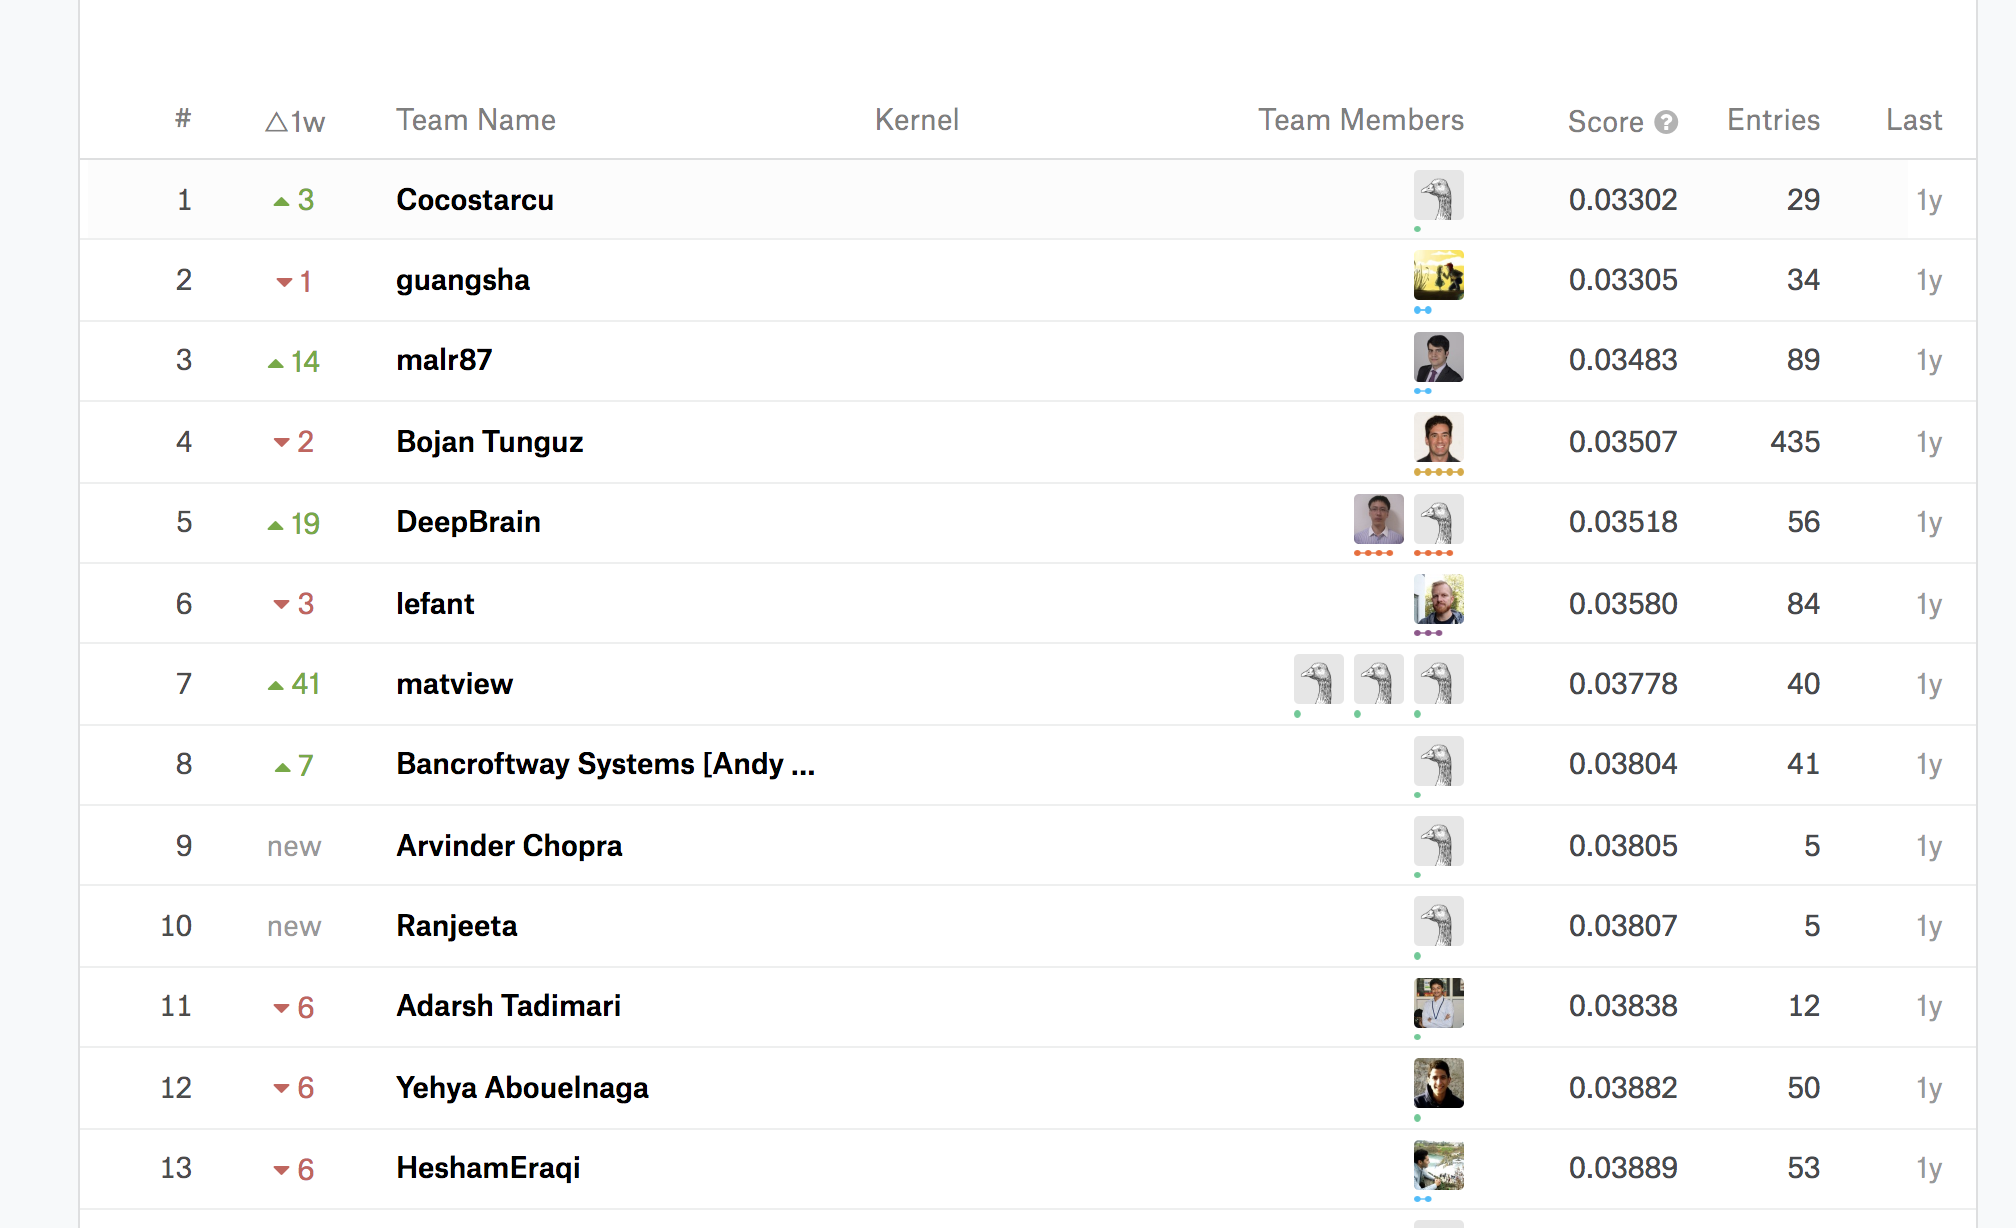

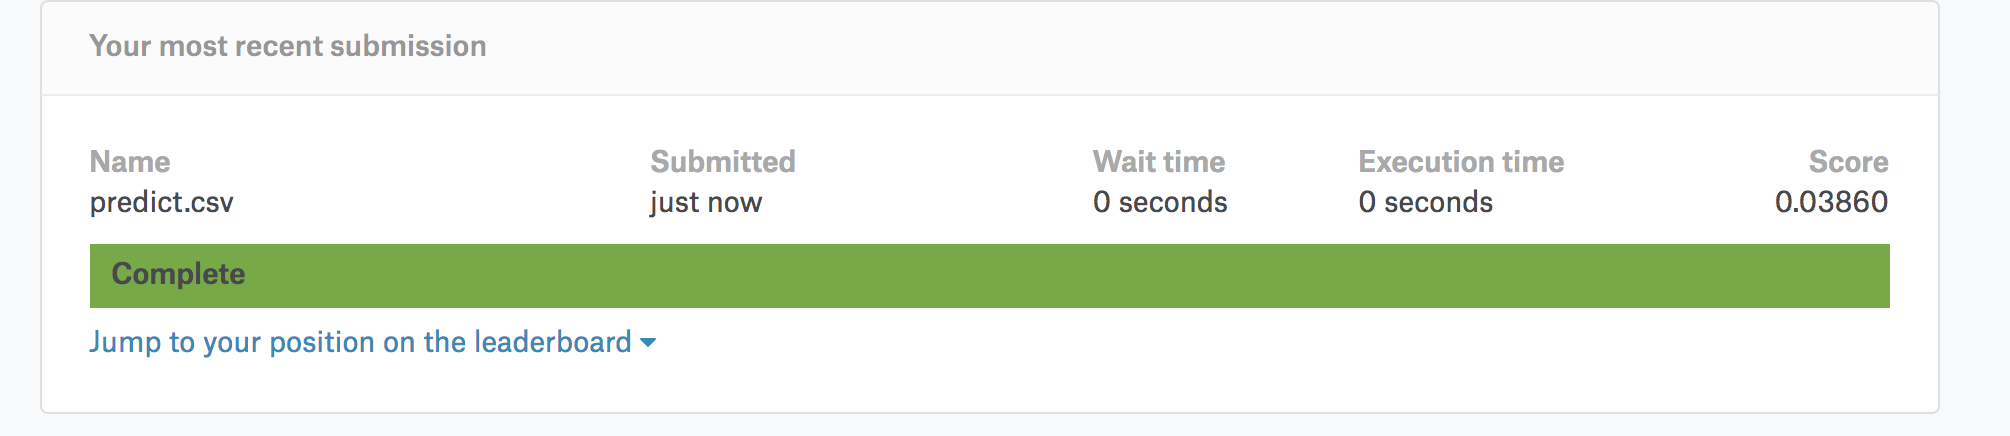

### 新图进来之后的流程(完整)

In [1]:
def predict(input_image):
    if input_image is None:
        return 
    if type(input_image) != type(np.array()):
        return 
    # resnet model
    res = Model(inputs=model.input,outputs=model.layers[-3].output)
    inception = Model(inputs=inception_model.input,outputs=inception_model.layers[-3].output)
    xcep = Model(inputs=xcep_model.input,outputs=xcep_model.layers[-3].output)
    
    res_feature = res.predict(np.expand_dims(cv2.resize(input_image,(224,224)),axis=0))
    incep_feature = inception.predict(np.expand_dims(cv2.resize(input_image,(299,299)),axis=0))
    xcep_feature = xcep.predict(np.expand_dims(cv2.resize(input_image,(299,299)),axis=0))